#### Transfer learning with tensorflow part 2: Fine tuning

In [ ]:
!nvidia-smi

Thu May 19 03:33:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-05-19 03:33:48--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-05-19 03:33:48 (51.9 MB/s) - ‘helper_functions.py’ saved [10246/10246]



Import helper functions

In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir # re-download the helper_functions.py when google colab disconnects

#### Get data from tf.keras.applications and apply them to our own problem

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip # import our dataset from github

unzip_data("10_food_classes_10_percent.zip") # unzip the file using unzip_data function

--2022-05-19 03:33:51--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   198MB/s    in 0.8s    

2022-05-19 03:33:52 (198 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent") # walk through function with os

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

#### Create training and test directory paths

In [ ]:
train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.python.ops.gen_array_ops import BatchToSpace
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMAGE_SHAPE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=IMAGE_SHAPE,
                                                                label_mode="categorical",
                                                                batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
train_data_10_percent

<BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))>

#### Check out the class names

In [ ]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [ ]:
for images, labels in train_data_10_percent.take(1): # take function splits the data into tuples of images and labels
  print(images, labels)

tf.Tensor(
[[[[1.94811218e+02 1.47882645e+02 1.22025513e+02]
   [1.91168365e+02 1.44882660e+02 1.15188774e+02]
   [1.97045914e+02 1.52755096e+02 1.18765305e+02]
   ...
   [3.42397156e+01 4.08264923e+01 4.89642334e+01]
   [2.58880100e+01 3.36022949e+01 4.12451515e+01]
   [7.20464020e+01 8.10464020e+01 8.80464020e+01]]

  [[1.92806122e+02 1.49734695e+02 1.15306122e+02]
   [1.92785721e+02 1.49714294e+02 1.15285713e+02]
   [2.01392853e+02 1.57892868e+02 1.25005104e+02]
   ...
   [1.29229584e+02 1.40372452e+02 1.46372452e+02]
   [9.66224289e+01 1.05765289e+02 1.12693863e+02]
   [1.22250717e+02 1.31250717e+02 1.38250717e+02]]

  [[1.91525513e+02 1.45954086e+02 1.28382645e+02]
   [1.64479584e+02 1.18122437e+02 9.97652969e+01]
   [1.39397949e+02 9.27806015e+01 7.25612106e+01]
   ...
   [1.32214264e+02 1.46785690e+02 1.51999985e+02]
   [1.34561111e+02 1.45448853e+02 1.51504990e+02]
   [1.17535553e+02 1.24964127e+02 1.32749847e+02]]

  ...

  [[2.86223936e+00 3.86223936e+00 8.07653332e+00]
   [6

#### Tensorflow functional API

1. Create a base model
2. Freeze the base model
3. Create inputs into base model
4. For ResNet50V2, add Rescaling to speed up model
5. Pass the inputs to the base model
6. Average pool the outputs
7. Create the output activation layer
8. Combine the inputs with the outputs
9. Compile the model
10. Fit the model

In [ ]:
# 1.create the base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False) # change ouput layer to include only your own classes

# 2. freeze the base model so that the underlying pre-trained patterns are not updated during training
base_model.trainable = False

# 3. create inputs into our model
inputs = tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

# 4. rescale the inputs for resnet50v2 only
# x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

# 5. pass the inputs to the base_model
x = base_model(inputs)
print(f"Shape after passing inputs through base model: {x.shape}")

# 6. average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shape after GlobalAveragePooling2D: {x.shape}")

# 7. create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# 8. combine the inputs with the outputs into the model
model_0 = tf.keras.Model(inputs, outputs)

# 9. compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 10. fit the model
history_0 = model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                   experiment_name="10_percent_feature_extraction")]) 

Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after GlobalAveragePooling2D: (None, 1280)
Saving TensorBoard log files to: transfer_learning/10_percent_feature_extraction/20220519-042542
Epoch 1/5
24/24 [==============================] - 11s 212ms/step - loss: 1.9045 - accuracy: 0.4053 - val_loss: 1.3356 - val_accuracy: 0.7089
Epoch 2/5
24/24 [==============================] - 5s 186ms/step - loss: 1.1528 - accuracy: 0.7320 - val_loss: 0.8894 - val_accuracy: 0.8076
Epoch 3/5
24/24 [==============================] - 5s 184ms/step - loss: 0.8515 - accuracy: 0.7920 - val_loss: 0.7467 - val_accuracy: 0.8207
Epoch 4/5
24/24 [==============================] - 5s 183ms/step - loss: 0.7037 - accuracy: 0.8280 - val_loss: 0.6386 - val_accuracy: 0.8355
Epoch 5/5
24/24 [==============================] - 5s 185ms/step - loss: 0.5992 - accuracy: 0.8467 - val_loss: 0.5902 - val_accuracy: 0.8520


In [ ]:
# evaluate the model
model_0.evaluate(test_data)

79/79 [==============================] - 6s 71ms/step - loss: 0.6148 - accuracy: 0.8396


[0.6148046851158142, 0.8396000266075134]

In [ ]:
for layer_number, layer in enumerate(base_model.layers): # check the layers in the pre-trained model
  print(layer_number, layer.name)

0 input_4
1 rescaling_3
2 normalization_3
3 stem_conv_pad
4 stem_conv
5 stem_bn
6 stem_activation
7 block1a_dwconv
8 block1a_bn
9 block1a_activation
10 block1a_se_squeeze
11 block1a_se_reshape
12 block1a_se_reduce
13 block1a_se_expand
14 block1a_se_excite
15 block1a_project_conv
16 block1a_project_bn
17 block2a_expand_conv
18 block2a_expand_bn
19 block2a_expand_activation
20 block2a_dwconv_pad
21 block2a_dwconv
22 block2a_bn
23 block2a_activation
24 block2a_se_squeeze
25 block2a_se_reshape
26 block2a_se_reduce
27 block2a_se_expand
28 block2a_se_excite
29 block2a_project_conv
30 block2a_project_bn
31 block2b_expand_conv
32 block2b_expand_bn
33 block2b_expand_activation
34 block2b_dwconv
35 block2b_bn
36 block2b_activation
37 block2b_se_squeeze
38 block2b_se_reshape
39 block2b_se_reduce
40 block2b_se_expand
41 block2b_se_excite
42 block2b_project_conv
43 block2b_project_bn
44 block2b_drop
45 block2b_add
46 block3a_expand_conv
47 block3a_expand_bn
48 block3a_expand_activation
49 block3a_d

In [ ]:
base_model.summary() # summary of the base_model

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_3 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 normalization_3 (Normalization  (None, None, None,   7          ['rescaling_3[0][0]']            
 )                              3)                                                   

In [ ]:
model_0.summary() # summary of our model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


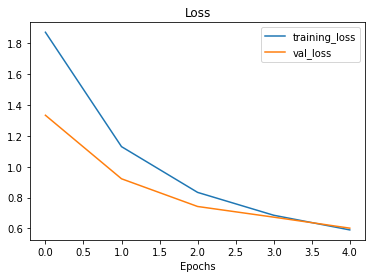

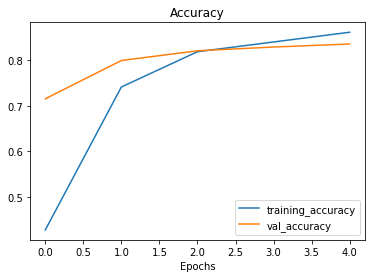

In [ ]:
plot_loss_curves(history_0) # plot the loss curves with the helper function from helper.py

#### Get a feature vactor from a trained model

`base_model` has a tensor of (None, 7, 7, 1280) but once it passes through the GlobalAveragePooling2D, it converts into (None, 1280)

Try with a similar tensor (1, 4, 4, 3) to view this in action

In [ ]:
input_shape = (1, 4, 4, 3) # define the input shape

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor:\n {input_tensor}\n") # create a random tensor

global_average_pooling_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor) # pass the random tensor into the GlobalAveragePooling2D layer
print(f"2D global average pooled random tensor:\n {global_average_pooling_tensor}\n")

print(f"Shape of input tensor: {input_tensor.shape}") # shape of input vector
print(f"Shape of the Global Average Pooled 2D tensor: {global_average_pooling_tensor.shape}") # shape of the vector after passing through

Random input tensor:
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]

2D global average pooled random tensor:
 [[-0.09368646 -0.45840448 -0.2885598 ]]

Shape of input tensor: (1, 4, 4, 3)
Shape of the Global Average Pooled 2D tensor: (1, 3)


#### Replicate the Global Average Pooled 2D layer 

In [ ]:
tf.reduce_mean(input_tensor, axis=[1, 2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

#### Try with Global Max Pooled 2D layer

In [ ]:
global_max_pooling_tensor = tf.keras.layers.GlobalMaxPooling2D()(input_tensor)
print(f"2D Global Max Pooled random tensor:\n {global_max_pooling_tensor}\n")
print(f"Shape of Global Max Pooled 2D tensor: {global_max_pooling_tensor.shape}")

2D Global Max Pooled random tensor:
 [[0.9058464 1.1603122 1.6994323]]

Shape of Global Max Pooled 2D tensor: (1, 3)


#### Run a series of transfer learning experiments

1. `model_1` => use feature extraction transfer learning with only 1% of the data with data augmentation
2. `model_2` => use feature extraction transfer learning with 10% of the data with data augmentation
3. `model_3` => use fine-tuning transfer learning with 10% of the data with data augmentation
4. `model_4` => use fine-tuning transfer learning with 100% of the data with data augmentation

Get and preprocess the data for `model_1`

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip # import data with !wget

unzip_data("10_food_classes_1_percent.zip") # unzip the data with unzip_data() helper function

--2022-05-19 03:35:05--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.128, 74.125.199.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M   277MB/s    in 0.5s    

2022-05-19 03:35:06 (277 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [ ]:
train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_1_percent/test/" # create the training and test directories

In [ ]:
walk_through_dir("10_food_classes_1_percent") # walk through the directories with helper function from helper.py

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/test'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_1_percent/test/pizza'

In [ ]:
IMG_SIZE = (224, 224)
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_1_percent,
                                                                           label_mode="categorical",
                                                                           image_size=IMG_SIZE,
                                                                           batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE) # set up data loaders

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Add data augmentation into the model directly

`tf.keras.layers.experimental.preprocessing()`

In [ ]:
print(tf.__version__)

2.8.0


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

data_augmentation = keras.Sequential([
                                      preprocessing.RandomFlip("horizontal"),
                                      preprocessing.RandomRotation(0.2),
                                      preprocessing.RandomZoom(0.2),
                                      preprocessing.RandomHeight(0.2),
                                      preprocessing.RandomWidth(0.2),
                                      # preprocessing.Rescale(1./255) # rescale for resnet50v2
], name="data_augmentation")

#### Data augmentation is turned on during training and turned off during testing

#### Visualize the data augmentation layer

View a random image and compare it with its augmented version

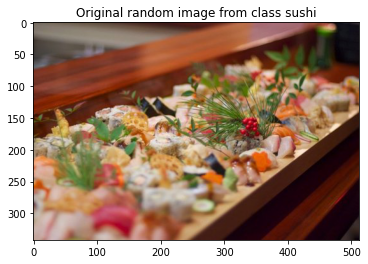

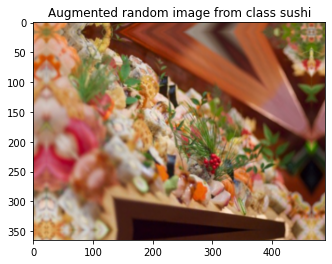

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
import tensorflow as tf

target_class = random.choice(train_data_1_percent.class_names)
target_dir = "10_food_classes_1_percent/train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image

img = mpimg.imread(random_image_path) # read in and plot the original random image
plt.imshow(img)
plt.title(f"Original random image from class {target_class}")
plt.axis=False

augmented_image = data_augmentation(tf.expand_dims(img, axis=0), training=True) # plot the augmented image
plt.figure()
plt.imshow(tf.squeeze(augmented_image)/255.)
plt.title(f"Augmented random image from class {target_class}")
plt.axis=False

#### `model_1`: Feature extraction transfer learning on 1% of the data with data augmentation

In [ ]:
# set up input shape and base model, freezing the base model layers
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create the input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

# add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

# give base_model the inputs
x = base_model(x, training=False)

# pool output features of the base_model
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# add a Dense layer as the output
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)

# create the model using the input and outputs
model_1 = keras.Model(inputs, outputs)

# compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# fit the model
history_1 = model_1.fit(train_data_1_percent,
                        epochs=5,
                        steps_per_epoch=len(train_data_1_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/1_percent_data_aug/20220519-033511
Epoch 1/5
3/3 [==============================] - 11s 2s/step - loss: 2.3912 - accuracy: 0.1286 - val_loss: 2.2415 - val_accuracy: 0.1694
Epoch 2/5
3/3 [==============================] - 3s 1s/step - loss: 2.1167 - accuracy: 0.2429 - val_loss: 2.1241 - val_accuracy: 0.2171
Epoch 3/5
3/3 [==============================] - 4s 2s/step - loss: 2.0062 - accuracy: 0.3429 - val_loss: 2.0152 - val_accuracy: 0.2862
Epoch 4/5
3/3 [==============================] - 7s 3s/step - loss: 1.8314 - accuracy: 0.4571 - val_loss: 1.9185 - val_accuracy: 0.3618
Epoch 5/5
3/3 [==============================] - 3s 1s/step - loss: 1.6273 - accuracy: 0.6286 - val_loss: 1.8537 - val_accuracy: 0.3914


In [ ]:
model_1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
results_1_percent_data_aug = model_1.evaluate(test_data)
results_1_percent_data_aug

79/79 [==============================] - 8s 91ms/step - loss: 1.8475 - accuracy: 0.4124


[1.8474836349487305, 0.4124000072479248]

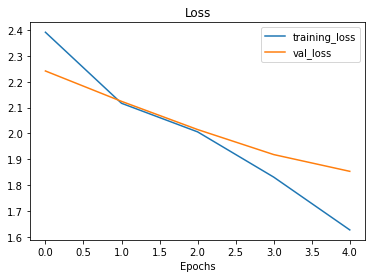

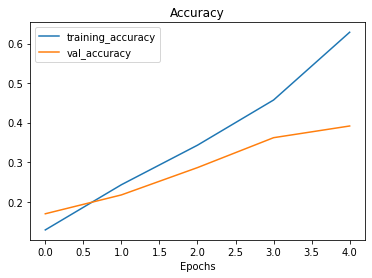

In [ ]:
plot_loss_curves(history_1) # use plot_loss_curves function from helper.py

#### `model_2`: Feature extraction transfer learning on 10% data and data augmentation

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip # get the data with !wget

train_dir_10_percent = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

--2022-05-19 03:35:55--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 142.250.99.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   239MB/s    in 0.7s    

2022-05-19 03:35:55 (239 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [ ]:
walk_through_dir("10_food_classes_10_percent") # helper function from helper.py

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent

In [ ]:
import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir_10_percent,
                                                                            label_mode="categorical",
                                                                            image_size=IMG_SIZE,
                                                                            batch_size=BATCH_SIZE) # set data inputs

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)
                                                               

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [ ]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, None, None, 3)     0         
                                                                 
 random_rotation (RandomRota  (None, None, None, 3)    0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, None, None, 3)     0         
                                                                 
 random_height (RandomHeight  (None, None, None, 3)    0         
 )                                                               
                                                                 
 random_width (RandomWidth)  (None, None, None, 3)     0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

#### Create `model_2` with data augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.models import Sequential # import dependencies

# build the data augmentation layer
data_augmentation = Sequential([
                                preprocessing.RandomFlip("horizontal"),
                                preprocessing.RandomHeight(0.2),
                                preprocessing.RandomWidth(0.2),
                                preprocessing.RandomZoom(0.2),
                                preprocessing.RandomRotation(0.2)
                                # preprocessing.Rescaling(1./255)
], name="data_augmentation")

# set up the input shape 
input_shape = (224, 224, 3)

# create a frozen base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# create the inputs and outputs
inputs = layers.Input(shape=input_shape, name="input_layer")
x = data_augmentation(inputs) # augment our training images
x = base_model(x, training=False) # pass augmented images in inference mode and batchnorm do not get updated
x = layers.GlobalAveragePooling2D(name="global_average_pooling_2D")(x)
outputs = layers.Dense(10, activation="softmax", name="output_layer")(x)
model_2 = tf.keras.Model(inputs, outputs)

# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_2.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_2D (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [ ]:
model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


#### Create a ModelCheckpoint callback

* Saves our model during training.

In [ ]:
# set checkpoint path
checkpoint_path = "ten_percent_model_checkpoints_weights/checkpoint.ckpt"

# create a model checkpoint callback that saves the weights only
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         save_best_only=False,
                                                         save_freq="epoch", # save the epoch
                                                         verbose=1)

#### Fit `model_2` and pass in the ModelCheckpoint callback function

In [ ]:
initial_epochs = 5 # fit the model saving checkpoint every epoch
history_2 = model_2.fit(train_data_10_percent,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data_10_percent),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="10_percent_data_aug"),
                                   checkpoint_callback])

Saving TensorBoard log files to: transfer_learning/10_percent_data_aug/20220519-033559
Epoch 1/5
24/24 [==============================] - ETA: 0s - loss: 2.0278 - accuracy: 0.3240
Epoch 1: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 21s 555ms/step - loss: 2.0278 - accuracy: 0.3240 - val_loss: 1.5083 - val_accuracy: 0.6447
Epoch 2/5
24/24 [==============================] - ETA: 0s - loss: 1.3804 - accuracy: 0.6720
Epoch 2: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 419ms/step - loss: 1.3804 - accuracy: 0.6720 - val_loss: 1.0662 - val_accuracy: 0.7533
Epoch 3/5
24/24 [==============================] - ETA: 0s - loss: 1.0732 - accuracy: 0.7307
Epoch 3: saving model to ten_percent_model_checkpoints_weights/checkpoint.ckpt
24/24 [==============================] - 11s 442ms/step - loss: 1.0732 - accuracy: 0.7307 - val_loss: 0.8667 - val_accuracy: 0.7829
E

In [ ]:
model_0.evaluate(test_data)

79/79 [==============================] - 9s 86ms/step - loss: 0.6159 - accuracy: 0.8328


[0.615874707698822, 0.8327999711036682]

In [ ]:
results_10_percent_data_aug = model_2.evaluate(test_data)
results_10_percent_data_aug

79/79 [==============================] - 7s 83ms/step - loss: 0.7009 - accuracy: 0.8064


[0.7008739113807678, 0.8064000010490417]

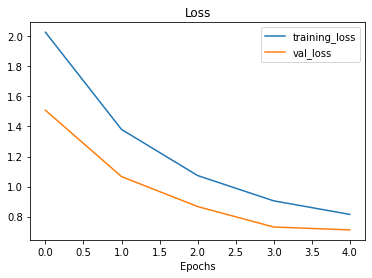

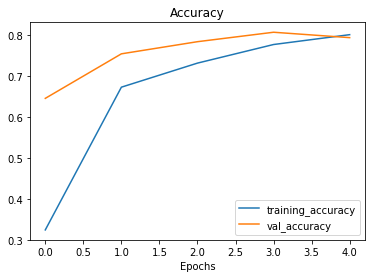

In [ ]:
# plot model's loss curves
plot_loss_curves(history_2)

#### Load in checkpointed weights which returns a model to a specific checkpoint

In [ ]:
# load in saved model weights and evaluate the model
model_2.load_weights(checkpoint_path)

In [ ]:
loaded_weights_model_results = model_2.evaluate(test_data) # evaluate model_2 with loaded weights

79/79 [==============================] - 7s 77ms/step - loss: 0.7009 - accuracy: 0.8064


In [ ]:
results_10_percent_data_aug == loaded_weights_model_results

False

In [ ]:
results_10_percent_data_aug

[0.7008739113807678, 0.8064000010490417]

In [ ]:
loaded_weights_model_results

[0.7008740305900574, 0.8064000010490417]

#### Check to see if model results are very close

In [ ]:
import numpy as np
np.isclose(np.array(results_10_percent_data_aug), np.array(loaded_weights_model_results))

array([ True,  True])

In [ ]:
# check the difference between the 2 results
print(np.array(results_10_percent_data_aug) - np.array(loaded_weights_model_results))

[-1.1920929e-07  0.0000000e+00]


#### `model_3`: Fine-tuning an existing model on 10% of the data

* Fine-tuning usually works best after training a feature extraction model for a few epochs with large amounts of custom data

In [ ]:
# layers in the loaded model
model_2.layers

In [ ]:
for layer in model_2.layers:
  print(layer, layer.trainable) # check if the layers are trainable

<keras.engine.input_layer.InputLayer object at 0x7f8ec49e0910> True
<keras.engine.sequential.Sequential object at 0x7f8ec730d1d0> True
<keras.engine.functional.Functional object at 0x7f8ec6e07dd0> False
<keras.layers.pooling.GlobalAveragePooling2D object at 0x7f8ec730db10> True
<keras.layers.core.dense.Dense object at 0x7f8ec6de1f10> True


In [ ]:
for i, layer in enumerate(model_2.layers[2].layers):
  print(i, layer.name, layer.trainable) # check the layers with EfficientNetB0 layer

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# check the number of trainable variables are in the base_model
print(len(model_2.layers[2].trainable_variables))

0


#### Set the last 10 layers of the `base_model.trainable == True` 

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:-10]:
  layer.trainable = False # freeze all layers except the last 10

# recompile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lower the learning rate by 10x when fine-tuning
                metrics=["accuracy"])

In [ ]:
# check which layers are trainable
for layer_number, layer in enumerate(model_1.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
print(len(model_2.trainable_variables)) # number of trainable variables

12


In [ ]:
model_2.trainable_variables

[<tf.Variable 'block7a_se_reduce/kernel:0' shape=(1, 1, 1152, 48) dtype=float32, numpy=
 array([[[[-0.05485657,  0.07178846,  0.01534605, ..., -0.09284662,
            0.0104828 , -0.02693838],
          [-0.03157939,  0.02819107, -0.05579546, ...,  0.00487578,
            0.12001809, -0.06901816],
          [-0.07792544,  0.12601745,  0.03935236, ...,  0.03086486,
           -0.01581392,  0.1306234 ],
          ...,
          [-0.07692936,  0.19920062,  0.17471024, ...,  0.03312391,
           -0.04528928, -0.09214652],
          [ 0.01010198,  0.06855008,  0.05820991, ...,  0.00131649,
           -0.08952942, -0.00476829],
          [ 0.03583075, -0.01228165,  0.04561347, ..., -0.00822134,
           -0.07354517, -0.06507882]]]], dtype=float32)>,
 <tf.Variable 'block7a_se_reduce/bias:0' shape=(48,) dtype=float32, numpy=
 array([-0.10886215, -0.13624744, -0.15257476,  0.14799541, -0.08512902,
        -0.12059905, -0.08779966, -0.08187538, -0.06925284, -0.12518929,
        -0.0819265 ,

#### Fine-tune the model for another 5 epochs

In [ ]:
fine_tune_epochs = initial_epochs + 5

# refit the model
history_2_fine = model_2.fit(train_data_10_percent,
                              epochs=fine_tune_epochs,
                              steps_per_epoch=len(train_data_10_percent),
                              validation_data=test_data,
                              validation_steps=int(0.25 * len(test_data)),
                              initial_epoch=history_2.epoch[-1], # start training from the previuos last epoch
                              callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                     experiment_name="10_percent_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/10_percent_fine_tune_last_10/20220519-033743
Epoch 5/10
24/24 [==============================] - 21s 477ms/step - loss: 0.7066 - accuracy: 0.8067 - val_loss: 0.5469 - val_accuracy: 0.8158
Epoch 6/10
24/24 [==============================] - 10s 373ms/step - loss: 0.5626 - accuracy: 0.8187 - val_loss: 0.5064 - val_accuracy: 0.8224
Epoch 7/10
24/24 [==============================] - 11s 448ms/step - loss: 0.4751 - accuracy: 0.8613 - val_loss: 0.5427 - val_accuracy: 0.8026
Epoch 8/10
24/24 [==============================] - 10s 404ms/step - loss: 0.4479 - accuracy: 0.8600 - val_loss: 0.4975 - val_accuracy: 0.8289
Epoch 9/10
24/24 [==============================] - 9s 364ms/step - loss: 0.4012 - accuracy: 0.8760 - val_loss: 0.4943 - val_accuracy: 0.8322
Epoch 10/10
24/24 [==============================] - 9s 359ms/step - loss: 0.3921 - accuracy: 0.8733 - val_loss: 0.5206 - val_accuracy: 0.8322


In [ ]:
# evaluate the fine-tuned model
results_fine_tune_10_percent = model_2.evaluate(test_data)

79/79 [==============================] - 7s 89ms/step - loss: 0.4766 - accuracy: 0.8400


In [ ]:
results_10_percent_data_aug # results_fine_tune_10_percent has a better accuracy than results_10_percent_data_aug

[0.7008739113807678, 0.8064000010490417]

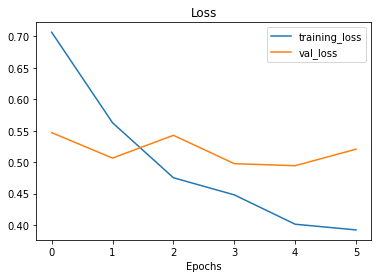

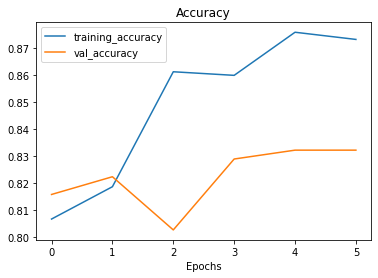

In [ ]:
plot_loss_curves(history_2_fine) # inaccurate because the plot_loss_curves only shows the first 5 epochs when we ran 10 epochs

#### Create a function to compare training histories

In [ ]:
def compare_historys(original_history, new_history, initial_epochs=5):
  """
  Compare 2 tensorflow history objects.
  """

  # get the original measurements
  acc = original_history.history["accuracy"]
  loss = original_history.history["loss"]

  val_acc = original_history.history['val_accuracy']
  val_loss = original_history.history["val_loss"]

  # add both historys
  total_acc = acc + new_history.history["accuracy"]
  total_loss = loss + new_history.history["loss"]

  total_val_acc = val_acc + new_history.history["val_accuracy"]
  total_val_loss = val_loss + new_history.history["val_loss"]

  # plot accuracy and vsal_accuracy
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 1)
  plt.plot(total_acc, label="Training Accuracy")
  plt.plot(total_val_acc, label="Training Val Accuracy")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine-Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Accuracy")

  # plot loss and val_loss
  plt.figure(figsize=(8, 8))
  plt.subplot(2, 1, 2)
  plt.plot(total_loss, label="Training Loss")
  plt.plot(total_val_loss, label="Training Val Loss")
  plt.plot([initial_epochs-1, initial_epochs-1], plt.ylim(), label="Start Fine-Tuning")
  plt.legend(loc="lower right")
  plt.title("Training and Validation Loss")

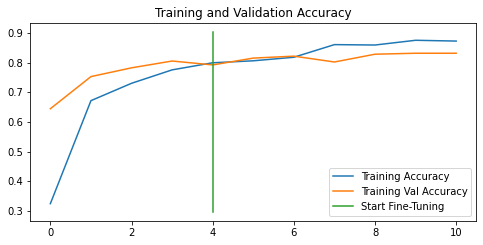

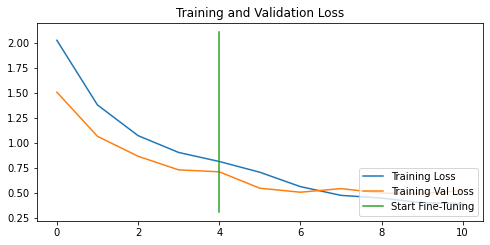

In [ ]:
compare_historys(history_2,
                 history_2_fine,
                 initial_epochs=5)

#### `model_4`: Fine-tuning an existing model on 100% of the data with data augmentation

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip # import 100% of the data

unzip_data("10_food_classes_all_data.zip") # unzip with helper function and use path name after the last "/"

--2022-05-19 03:39:16--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_all_data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519183241 (495M) [application/zip]
Saving to: ‘10_food_classes_all_data.zip’

10_food_classes_all 100%[===================>] 495.13M   235MB/s    in 2.1s    

2022-05-19 03:39:19 (235 MB/s) - ‘10_food_classes_all_data.zip’ saved [519183241/519183241]



#### Set up training and test directories

In [ ]:
train_dir_all_data = "10_food_classes_all_data/train/"
test_dir = "10_food_classes_all_data/test/"

In [ ]:
walk_through_dir("10_food_classes_all_data") # walk through path

There are 2 directories and 0 images in '10_food_classes_all_data'.
There are 10 directories and 0 images in '10_food_classes_all_data/test'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ice_cream'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/steak'.
There are 0 directories and 250 images in '10_food_classes_all_data/test/pizza'.
There are 

#### Convert data into tensors

In [ ]:
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_10_classes_full = tf.keras.preprocessing.image_dataset_from_directory(train_dir_all_data,
                                                                                 label_mode="categorical",
                                                                                 image_size=IMG_SIZE,
                                                                                 batch_size=BATCH_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                batch_size=BATCH_SIZE)

Found 7500 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


#### Test dataset is the same throughout all models

In [ ]:
model_2.evaluate(test_data)

79/79 [==============================] - 7s 80ms/step - loss: 0.4766 - accuracy: 0.8400


[0.47656533122062683, 0.8399999737739563]

In [ ]:
results_fine_tune_10_percent

[0.4765653908252716, 0.8399999737739563]

In [ ]:
model_2.evaluate(test_data)[0] == results_fine_tune_10_percent[0] # verify loss between both results

79/79 [==============================] - 6s 72ms/step - loss: 0.4766 - accuracy: 0.8400


False

#### Revert back `model_2` weights to train a fine tuned model

- The same stage where the model was fine-tune from

In [ ]:
model_2.load_weights(checkpoint_path)

In [ ]:
model_2.evaluate(test_data) # evaluate from the point before fine-tuning

79/79 [==============================] - 7s 84ms/step - loss: 0.7009 - accuracy: 0.8064


[0.7008739709854126, 0.8064000010490417]

In [ ]:
results_10_percent_data_aug # model_2 is reverted back into its initial stage

[0.7008739113807678, 0.8064000010490417]

#### Steps we have done:

1. Trained a feature extraction transfer learning model for 5 epochs on 10% of the data with data augmentation and we saved the model's weights using `ModelCheckpoint` callback
2. Fine-tuned the same model on 10% of the data for a further 5 epochs with the top 10 layers unfrozen
3. Saved the results and training logs each time
4. Reloaded the model from step 1 to do the same steps as steps 2 except we are using 100% of the data instead of 10% only

In [ ]:
# check which layers are trainable
for layer_number, layer in enumerate(model_2.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer True
1 data_augmentation True
2 efficientnetb0 True
3 global_average_pooling_2D True
4 output_layer True


In [ ]:
for layer_number, layer in enumerate(model_2.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [ ]:
# compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # advised to lower learning rate by 10x
                metrics=["accuracy"])

In [ ]:
fine_tune_epochs = initial_epochs + 5

history_4 = model_2.fit(train_data_10_classes_full,
                        epochs=fine_tune_epochs,
                        steps_per_epoch=len(train_data_10_classes_full),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data)),
                        initial_epoch=history_2.epoch[-1], # history.epoch[-1]
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                               experiment_name="full_10_classes_fine_tune_last_10")])

Saving TensorBoard log files to: transfer_learning/full_10_classes_fine_tune_last_10/20220519-040529
Epoch 5/10
235/235 [==============================] - 61s 232ms/step - loss: 0.7349 - accuracy: 0.7612 - val_loss: 0.3901 - val_accuracy: 0.8734
Epoch 6/10
235/235 [==============================] - 54s 229ms/step - loss: 0.6056 - accuracy: 0.7979 - val_loss: 0.3219 - val_accuracy: 0.8980
Epoch 7/10
235/235 [==============================] - 51s 217ms/step - loss: 0.5261 - accuracy: 0.8305 - val_loss: 0.3005 - val_accuracy: 0.8947
Epoch 8/10
235/235 [==============================] - 43s 182ms/step - loss: 0.4860 - accuracy: 0.8412 - val_loss: 0.2746 - val_accuracy: 0.9062
Epoch 9/10
235/235 [==============================] - 41s 172ms/step - loss: 0.4546 - accuracy: 0.8531 - val_loss: 0.2910 - val_accuracy: 0.8980
Epoch 10/10
235/235 [==============================] - 38s 162ms/step - loss: 0.4159 - accuracy: 0.8647 - val_loss: 0.2534 - val_accuracy: 0.9046


In [ ]:
results_fine_tune_full_data = model_2.evaluate(test_data) # evaluate on all data
results_fine_tune_full_data

79/79 [==============================] - 7s 72ms/step - loss: 0.3115 - accuracy: 0.8960


[0.31152665615081787, 0.8960000276565552]

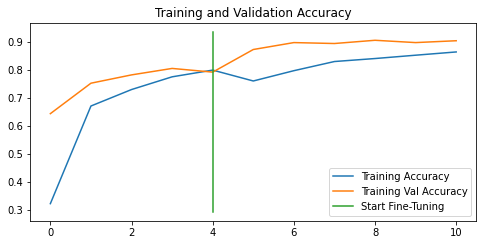

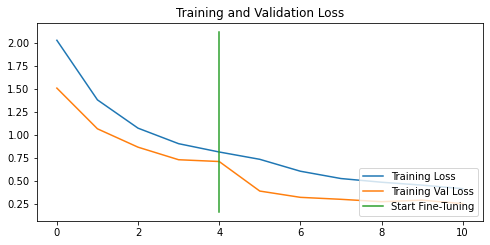

In [ ]:
compare_historys(original_history=history_2,
                 new_history=history_4,
                 initial_epochs=5)

#### View our experiment results in TensorBoard (public view)

In [ ]:
!tensorboard dev upload --logdir ./transfer_learning/ \
  --name "Transfer Learning Experiments with 10 Food 101 Classes" \
  --description "A series of different transfer learning experiments with varying amounts of data and fine-tuning." \
  --one_shot # exits the uploader once it finishes uploading


New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/AZ3BQxbeS6mfzV8kvzzdqA/

[2022-05-19T04:32:05] Started scanning logdir.
[2022-05-19T04:32:10] Total uploaded: 162 scalars, 0 tensors, 5 binary objects (4.1 MB)
[2022-05-19T04:32:10] Done scanning logdir.


Done. View your TensorBoard at https://tensorboard.dev/experiment/AZ3BQxbeS6mfzV8kvzzdqA/


#### Delete from TensorBoard

In [ ]:
!tensorboard dev list

https://tensorboard.dev/experiment/AZ3BQxbeS6mfzV8kvzzdqA/
	Name                 Transfer Learning Experiments with 10 Food 101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning.
	Id                   AZ3BQxbeS6mfzV8kvzzdqA
	Created              2022-05-19 04:32:05 (1 minute ago)
	Updated              2022-05-19 04:32:10 (1 minute ago)
	Runs                 10
	Tags                 5
	Scalars              162
	Tensor bytes         0
	Binary object bytes  4322439
https://tensorboard.dev/experiment/tObLgKL4Ql21I27lX4kBcg/
	Name                 Transfer Learning Experiments with 10 Food 101 Classes
	Description          A series of different transfer learning experiments with varying amounts of data and fine-tuning
	Id                   tObLgKL4Ql21I27lX4kBcg
	Created              2022-05-19 04:20:23 (13 minutes ago)
	Updated              2022-05-19 04:20:27 (13 minutes ago)
	Runs                 8
	Tags         

In [ ]:
# delete an experiment
# !tensorboard dev delete --experiment_id AZ3BQxbeS6mfzV8kvzzdqA 